# UMAP for bird-songs  
---

In [1]:
## Installs for Coursera (on terminal only)
# conda install -c conda-forge librosa umap-learn
# conda install -c plotly plotly=4.14.3

In [2]:
## Installs for CoLab
# !pip install umap-learn
# !pip install plotly==4.14.3

In [3]:
# # For Colab only
# # 4/1AY0e-g6CTocvBK45PWlJu2ycBuOMTgu36b-VZgpnCXitW_Vy3ckpGGBzur8
# from google.colab import drive
# drive.mount('content')
# # /content/content/MyDrive/bird-songs/audio

In [82]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
import os
from collections import OrderedDict
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

# Libraries for librosa
import librosa
import librosa.display

# Libraries for plotly charts
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

# Libraries for UMAP and t-SNE
from umap import UMAP
from sklearn.manifold import TSNE

# Libraries for matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
# Set general font size
plt.rcParams['font.size'] = '14'


# Check whether google drive mounted
path = '/content/content/MyDrive/bird-songs/'
if os.path.isdir(path) == True:
    print('Google Drive Mounted')
    run_on_colab = True
else:
    print('Using local drive')
    run_on_colab = False

Using local drive


In [59]:
# Define Global Varibles for analysis

SAMPLE_RATE = 22050 # Hz
SUBCLIP_SEC = 2.9 # sec
NUMBER_MFCC = 32
NUMBER_MEL = 20
FMIN = 4000 # Minimum Hz
N_FFT = 512 # Choose 2^n where n is integer
HOP_LENGTH = 256 # Choose equal, half, or quarter of N_FFT

In [162]:
def audio_path_filename(fileid):
    
    if run_on_colab == True:
        path_filename = '/content/content/MyDrive/bird-songs/audio_8sec/' + str(fileid) + '.wav'
                                
    else:
        path_filename = 'audio_8sec/' + str(fileid) + '.wav'
    
    return path_filename


def load_xeno_canto_data():
    '''
    '''

    if run_on_colab == True:
        df = pd.read_csv('/content/content/MyDrive/bird-songs/features_filtered.csv', encoding='latin')
    else:
        df = pd.read_csv('features_filtered.csv', encoding='latin')
        
    df.rename(columns={"id": "fileid"}, inplace=True)

#     test = df.groupby(['en', 'type']).count().reset_index()
#     display(test[test['type'].str.contains("call")])
#     df = df[df['type'].str.contains("song") | df['type'].str.contains("Song")]
#     df = df[~df['type'].str.contains("call")]
#     df = df[~df['type'].str.contains("Call")]
    

    # These are the top species we selected for our analysis
    selected_species = ['Red-winged Blackbird', 'Common Yellowthroat', 'Northern Cardinal', 
                        'Carolina Wren', 'Red Crossbill', 'Spotted Towhee']

    # We only need the fileid, labels, and type
    df = df[df.en.isin(selected_species)][['fileid', 'en', 'type']]
    
    # Now we need to change our labels into integers as torch does not support string format for labels.
    labels = {"Red-winged Blackbird": 0, 'Common Yellowthroat': 1, 'Northern Cardinal': 2,
              'Carolina Wren': 3,'Red Crossbill': 4, 'Spotted Towhee': 5}
    df['label'] = df.apply(lambda row: labels[row.en], axis=1)
    # Add filename and path
    df['filename'] = df['fileid'].apply(lambda x: audio_path_filename(x))
    df.set_index('fileid', inplace=True)
    
    return df


df_xeno_canto_import = load_xeno_canto_data()
display(df_xeno_canto_import.head(5))
print(len(df_xeno_canto_import))

,en,type,label,filename
fileid,,,,
564895,Carolina Wren,"adult, sex uncertain, song",3,audio_8sec/564895.wav
545775,Carolina Wren,call,3,audio_8sec/545775.wav
540857,Carolina Wren,song,3,audio_8sec/540857.wav
540855,Carolina Wren,song,3,audio_8sec/540855.wav
539275,Carolina Wren,"call, song",3,audio_8sec/539275.wav


2516


In [163]:
a = np.array([1,2,3])
b = np.tile(a,2)
c = np.array([7,9])
np.append(b,c, axis=0)

c[-0:]

array([7, 9])

  0%|          | 0/3 [00:00<?, ?it/s]

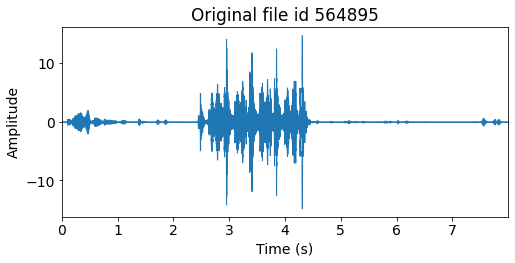

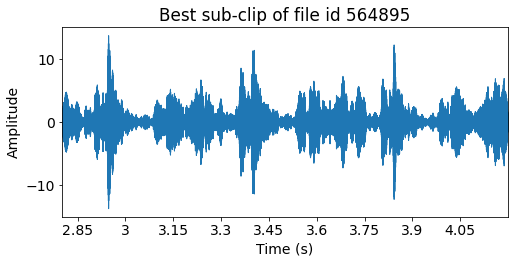

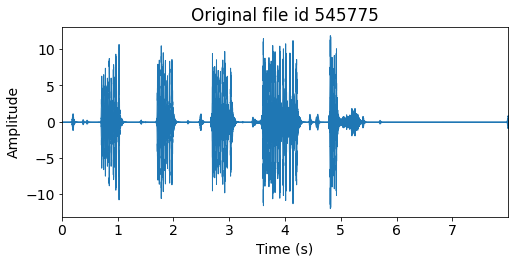

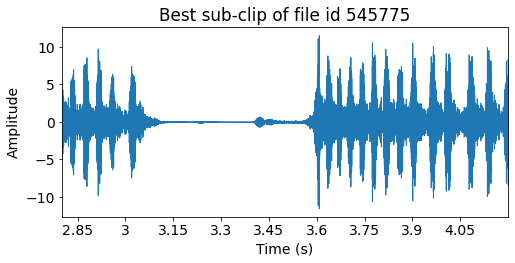

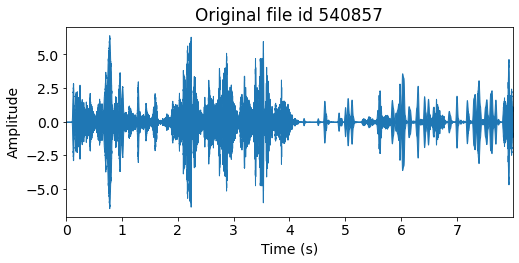

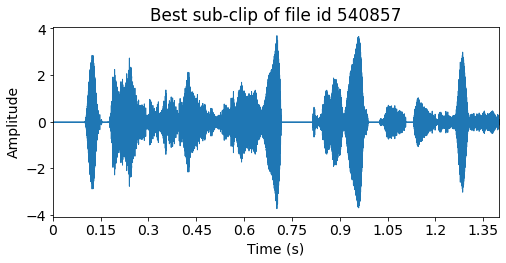

,en,type,label,filename,start,end
fileid,,,,,,
564895,Carolina Wren,"adult, sex uncertain, song",3,audio_8sec/564895.wav,61740.0,92610.0
545775,Carolina Wren,call,3,audio_8sec/545775.wav,61740.0,92610.0
540857,Carolina Wren,song,3,audio_8sec/540857.wav,0.0,30870.0
540855,Carolina Wren,song,3,audio_8sec/540855.wav,NaN,NaN
539275,Carolina Wren,"call, song",3,audio_8sec/539275.wav,NaN,NaN


In [183]:
def find_best_subclip(df, subclip_sec=1, sample_rate=22050):
    ''' '''
     
    if subclip_sec < 0 or subclip_sec > 50:
        print("Error: You must specify a subclip between 0 and 50 seconds")
        return pd.DataFrame()
    
    for fileid in tqdm(list(df.index)[:3]):
        
        y, sr = librosa.load(df.loc[fileid, 'filename'], sr=sample_rate, mono=True)
        
        ### Linear rms level and scaling factor
        # https://www.youtube.com/watch?v=zyqb06g51jw
        rms_level_db = 0
        sig = y
        r = 10**(rms_level_db / 20.0)
        a = np.sqrt( (len(sig) * r**2) / np.sum(sig**2) )
        # Normalized amplitude signal
        y_norm = y * a
        
        ### Calc length of audio clip and sub-clip in samples (i.e. not seconds)
        audio_length = len(y_norm)
        subclip_length = int(subclip_sec * sample_rate)
        
        ### Plot original audio file before any clipping or extending
        fig, ax = plt.subplots(figsize=(8, 3.5))
        librosa.display.waveplot(y_norm, sr, x_axis='s')
        plt.title(f'Original file id {fileid}')
        plt.ylabel('Amplitude')
        
        
        ### Here check if y is shorter than the subclip_sec and if so, wrap y until length = subclip_sec
        if audio_length < subclip_length:
            number_repeats = subclip_length // audio_length
            remaining_samples = subclip_length % audio_length
#             print(number_repeats, remaining_samples)
            # Create new audio clip y by repeat
            y_new_repeat = np.tile(y_norm,number_repeats)
            if remaining_samples > 0:
                y_new_remaining = y_norm[:remaining_samples]
                y_new = np.append(y_new_repeat, y_new_remaining, axis=0)
            else:
                y_new = y_new_repeat
            ### TO DO: Save this new file??
            
            #  Plot repeat audio file
            fig, ax = plt.subplots(figsize=(8, 3.5))
            librosa.display.waveplot(y_new, sr, x_axis='s')
            plt.ylabel('Amplitude')
            plt.title(f'File id {fileid} repeated to equal sub-clip length of {subclip_sec} sec')
#             print(f"The length of the new sample is {len(y_new)}")
            
            # Update start and stop index of repeated audio file
            df.loc[fileid,'start'] = 0
            df.loc[fileid,'end'] = len(y_new) + 1
            
            continue
        
        
        ### Calculate area of window for each hop along the audio waveform
#         print(f'length of audio clip is {int(audio_length/sample_rate)} sec, or {audio_length} samples')
#         print(f'The subclip length is {subclip_sec} sec, or {subclip_length} samples')
        hop_stride = int(min(subclip_length*sample_rate/5, audio_length/20))
#         print(f'Each window hop is {hop_stride/sample_rate} sec, or {hop_stride} samples')
        total_hops = int(audio_length / hop_stride)
#         print(f'There are {total_hops} total hops')
        
        # Store data on each hop
        hop_data = OrderedDict()
        hop_window_start = 0
        hop_window_end = subclip_length + 1
        hop=0
        # Clip negative amplitude values for area calculation for each hop
        y_norm_positive = y_norm.clip(min=0)
        
        # Keep hopping until just before a hop would overlap past the end of the audio file
        while hop_window_end <= audio_length:
            y_window = y_norm_positive[hop_window_start:hop_window_end]
            hop_window_area = np.trapz(y_window, dx = 1/sample_rate, axis=0)
            hop_data[hop] = [hop_window_start, hop_window_end, hop_window_area]
#             print(f"hop {hop} with start:end of {hop_data[hop][0]}:{hop_data[hop][1]} samples",
#                   f"{hop_data[hop][0]/sample_rate:.2f}:{(hop_data[hop][1]-1)/sample_rate:.2f} sec",
#                   f"and area of {hop_data[hop][2]:.4f}")
            hop_window_start += hop_stride
            hop_window_end += hop_stride
            hop += 1
            
        # Add one window hop to cover remaining area at end of file if skipped above
        if hop_window_end > audio_length:
            hop_window_start = audio_length - subclip_length
            y_window = y_norm_positive[hop_window_start:]
            hop_window_area = np.trapz(y_window, dx = 1/sample_rate, axis=0)
            hop_data[hop] = [hop_window_start, hop_window_end, hop_window_area]
#             print("Additional window to cover last portion of audio clip")
#             print(f"hop {hop} with start:end of {hop_data[hop][0]}:{hop_data[hop][1]} samples",
#                   f"{hop_data[hop][0]/sample_rate:.3f}:{(hop_data[hop][1]-1)/sample_rate:.3f} sec",
#                   f"and area of {hop_data[hop][2]:.4f}")
        
        
        ### Find hop with maximum area under the waveform. 
        maxhop = max(hop_data, key= lambda x: hop_data[x][-1])
#         print(f"\nHop with max area is hop {maxhop} with area of {hop_data[maxhop][2]:.4f}\n\n")
        max_y_window = y_norm_positive[hop_data[maxhop][0]:hop_data[maxhop][1]]
        max_start_window_seconds = hop_data[maxhop][0] / sample_rate

        # Plot sub-clip of max area
        fig, ax = plt.subplots(figsize=(8, 3.5))
        original_x_ticks =  list(np.arange(0, len(max_y_window) / sample_rate))
        librosa.display.waveplot(max_y_window, sr, offset = max_start_window_seconds, x_axis='s')
        plt.ylabel('Amplitude')
        plt.title(f'Best sub-clip of file id {fileid}')
        plt.show()
        # Store start and stop of sub-clip with max area
        df.loc[fileid,'start'] = hop_data[maxhop][0]
        df.loc[fileid,'end'] = hop_data[maxhop][1]
    
#    Uncomment only if running through all files otherwise will throw an error
#     df = df.astype({'start': 'int32', 'end': 'int32'})
  
    return df

df_xeno_canto = find_best_subclip(df=df_xeno_canto_import, subclip_sec=1.4, sample_rate=SAMPLE_RATE)
df_xeno_canto.head(5)

In [5]:
def create_mel_features_umap(df, n_mels=128, sample_rate=22050, best_subclip=False, save=False,
                             n_fft=1012, hop_length=512, fmin=500):
    ''' '''

    # Create df to hold mfcc spectral features
    df_mel = pd.DataFrame(columns = ['mel_max' + str(item+1) for item in list(range(n_mels))] +
                                    ['mel_std' + str(item+1) for item in list(range(n_mels))], 
                                    index=df.index)
        

    for fileid in tqdm(list(df.index)[:]):
        # Load audio file into librosa
        y, sr = librosa.load(df.loc[fileid, 'filename'], sr=sample_rate, mono=True)
        
        # Normalize audio file with linear rms level and scaling factor
        # https://www.youtube.com/watch?v=zyqb06g51jw
        rms_level_db = 0
        sig = y
        r = 10**(rms_level_db / 20.0)
        a = np.sqrt( (len(sig) * r**2) / np.sum(sig**2) )
        # Normalized amplitude signal
        y_norm = y * a
        # Clip file to best subclip, if requested
        if best_subclip==True:
            start = df.loc[fileid, 'start']
            end = df.loc[fileid, 'end']
            y_norm = y_norm[start:end]
        # Create mel spectrogram
        mels = librosa.feature.melspectrogram(y=y_norm, sr=sample_rate, n_mels=n_mels, 
                                              n_fft=n_fft, hop_length=hop_length, fmin=fmin)
        # Calculate maximum and std dev of intensities of audio clip time t at each mel frequency
        mels_maxs = [np.max(item) for item in mels]
        mels_stds = [np.std(item) for item in mels]
        # print("mel means:", mels_maxs, "\nmel std deviations:", mels_stds)
        df_mel.loc[fileid] = mels_maxs + mels_stds
  
    return df_mel


df_mel = create_mel_features_umap(df_xeno_canto, n_mels=NUMBER_MEL, sample_rate=SAMPLE_RATE, best_subclip=True,
                                  n_fft=N_FFT, hop_length=HOP_LENGTH, fmin=FMIN)
df_mel.head()

  0%|          | 0/2516 [00:00<?, ?it/s]

,mel_max1,mel_max2,mel_max3,mel_max4,mel_max5,mel_max6,mel_max7,mel_max8,mel_max9,mel_max10,...,mel_std11,mel_std12,mel_std13,mel_std14,mel_std15,mel_std16,mel_std17,mel_std18,mel_std19,mel_std20
fileid,,,,,,,,,,,,,,,,,,,,,
564895,0.0059,0.003564,0.002242,0.001726,0.000906,0.001081,0.000421,0.000411,0.000579,0.000589,...,0.008353,0.019107,0.043312,0.048813,0.000641,0.000021,0.000018,0.00003,0.000032,0.000022
545775,1079.014404,1462.817993,224.076416,74.846336,121.848419,54.26561,27.500628,27.334457,21.182169,10.232633,...,1.526282,0.594078,0.388016,0.185062,0.026912,0.006428,0.007284,0.004649,0.0043,0.004098
540857,0.000309,0.000495,0.000784,0.000889,0.001808,0.038586,0.148604,0.023446,0.059825,0.006208,...,0.000431,0.000156,0.000081,0.000055,0.000095,0.000054,0.000049,0.000023,0.000023,0.000016
540855,0.000019,0.000016,0.000013,0.000018,0.000016,0.000021,0.00004,0.000029,0.000021,0.000024,...,0.00011,0.000008,0.002094,0.000409,0.000005,0.000004,0.000004,0.000003,0.000004,0.000003
539275,78.223274,123.576645,295.882538,37.314861,0.280215,0.061404,0.035521,0.028657,0.038154,0.068914,...,0.003773,0.003263,0.003196,0.002522,0.002405,0.01451,0.034651,0.032325,0.001739,0.001515


In [6]:
def create_mfcc_spectral_df_xeno_canto(df, n_mfcc=128, sample_rate=22050, best_subclip=False,
                                       n_fft=1012, hop_length=512, fmin=500):
    ''' '''

    # Create df to hold mfcc spectral df_xeno_canto
    df_mfcc = pd.DataFrame(columns = ['mfcc_max' + str(item+1) for item in list(range(n_mfcc))] +
                                     ['mfcc_std' + str(item+1) for item in list(range(n_mfcc))], 
                                     index=df.index)
            
    for fileid in tqdm(list(df.index)[:]):
        # Load audio file into librosa
        y, sr = librosa.load(df.loc[fileid, 'filename'], sr=sample_rate, mono=True)
        # Normalize audio file with linear rms level and scaling factor
        # https://www.youtube.com/watch?v=zyqb06g51jw
        rms_level_db = 0
        sig = y
        r = 10**(rms_level_db / 20.0)
        a = np.sqrt( (len(sig) * r**2) / np.sum(sig**2) )
        # Normalized amplitude signal
        y_norm = y * a
        # Clip file to best subclip, if requested
        if best_subclip==True:
            start = df.loc[fileid, 'start']
            end = df.loc[fileid, 'end']
            y_norm = y_norm[start:end]
        # Create mfcc spectrogram
        mfccs = librosa.feature.mfcc(y=y_norm, sr=sample_rate, n_mfcc=n_mfcc, n_fft=N_FFT,
                                     hop_length=hop_length, fmin=fmin)
        # Calculate maximum and std dev of intensities of audio clip time t at each mfcc frequency
        mfcc_maxs = [np.max(item) for item in mfccs]
        mfcc_stds = [np.std(item) for item in mfccs]
        # print("mfcc means:", mfcc_maxs, "\nmfcc std deviations:", mfcc_stds)
        df_mfcc.loc[fileid] = mfcc_maxs + mfcc_stds
  
    return df_mfcc



df_mfcc = create_mfcc_spectral_df_xeno_canto(df_xeno_canto, n_mfcc=NUMBER_MFCC, sample_rate=SAMPLE_RATE,
                                             best_subclip=True, n_fft=N_FFT, hop_length=HOP_LENGTH, fmin=FMIN)
df_mfcc.head()

  0%|          | 0/2516 [00:00<?, ?it/s]

,mfcc_max1,mfcc_max2,mfcc_max3,mfcc_max4,mfcc_max5,mfcc_max6,mfcc_max7,mfcc_max8,mfcc_max9,mfcc_max10,...,mfcc_std23,mfcc_std24,mfcc_std25,mfcc_std26,mfcc_std27,mfcc_std28,mfcc_std29,mfcc_std30,mfcc_std31,mfcc_std32
fileid,,,,,,,,,,,,,,,,,,,,,
564895,-385.824921,63.952972,9.069546,48.583557,23.953693,0.720236,33.250225,24.594534,10.427937,32.821571,...,6.571469,8.335426,6.184735,7.961739,6.758663,8.548118,7.424845,6.185903,7.518748,5.843837
545775,-36.445133,289.465454,26.612701,57.796925,48.105595,20.010643,21.050436,11.475885,19.422525,25.891808,...,9.635854,7.371509,7.276379,6.164116,9.085259,6.394245,8.497727,6.394962,10.223057,6.786075
540857,-354.897949,52.957085,4.086617,3.981077,7.315048,31.552944,35.538483,9.713609,5.634933,9.403513,...,9.761474,5.616881,8.064094,6.085645,6.656801,7.646581,5.034227,6.801513,5.951066,4.387641
540855,-559.795593,-0.047454,4.29194,19.946301,16.996418,8.136826,17.693989,31.707882,12.251001,13.17939,...,6.620138,4.989453,7.662967,5.331115,6.860122,7.363475,5.159378,7.2634,6.990545,6.17013
539275,-151.197174,142.531769,169.803772,85.431412,41.465794,33.767181,0.094208,-0.198565,-3.541297,25.259678,...,7.627794,7.125955,7.394062,8.16513,6.793995,6.030301,6.938795,6.161572,9.010017,8.104055


In [7]:
def load_spherical_kmeans_features(file):
    ''' '''
    
    if run_on_colab == True:
        skmeans_features = np.load('/content/content/MyDrive/bird-songs/audio_8sec/' + file)
    else:
        skmeans_features = np.load(file)
    
    # Create df to hold sperical k means features
    df = pd.DataFrame(data = skmeans_features,
                      columns = ['skmeanfeat' + str(item+1) for item in list(range(skmeans_features.shape[1]))], 
                      index=df_xeno_canto.index)

    return df


df_skmean = load_spherical_kmeans_features('s_k_means_mel_features.npy')
df_skmean.head()

,skmeanfeat1,skmeanfeat2,skmeanfeat3,skmeanfeat4,skmeanfeat5,skmeanfeat6,skmeanfeat7,skmeanfeat8,skmeanfeat9,skmeanfeat10,...,skmeanfeat141,skmeanfeat142,skmeanfeat143,skmeanfeat144,skmeanfeat145,skmeanfeat146,skmeanfeat147,skmeanfeat148,skmeanfeat149,skmeanfeat150
fileid,,,,,,,,,,,,,,,,,,,,,
564895,0.000000,0.000000,0.016872,0.00000,0.000000,0.0,0.0,0.000976,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
545775,0.083864,0.689993,0.000000,0.47887,0.392199,0.0,0.0,0.000000,0.0,0.092081,...,0.076493,0.0,0.0,1.123438,0.0,0.0,0.0,0.0,0.0,0.0
540857,0.000000,0.000000,0.016865,0.00000,0.000000,0.0,0.0,0.000971,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
540855,0.000000,0.000000,0.016882,0.00000,0.000000,0.0,0.0,0.000977,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
539275,0.000000,0.000000,0.008969,0.00000,0.010318,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def create_df_umap(df1, df2, df3):

    df_umap_step1 = df1.merge(df2, how ='left', left_index=True, right_index=True)
    df_umap_step2 = df_umap_step1.merge(df3, how ='left', left_index=True, right_index=True)
    return df_umap_step2


df_umap = create_df_umap(df_xeno_canto, df_skmean, df_mel)

if run_on_colab == True:
    outfile = '/content/content/MyDrive/bird-songs/df_umap.pkl'
else:
    outfile = './df_umap.pkl'

df_umap.to_pickle(outfile)

display(df_umap.head())

,en,type,label,filename,start,end,skmeanfeat1,skmeanfeat2,skmeanfeat3,skmeanfeat4,...,mel_std11,mel_std12,mel_std13,mel_std14,mel_std15,mel_std16,mel_std17,mel_std18,mel_std19,mel_std20
fileid,,,,,,,,,,,,,,,,,,,,,
564895,Carolina Wren,"adult, sex uncertain, song",3,audio_8sec/564895.wav,88200,92611,0.000000,0.000000,0.016872,0.00000,...,0.008353,0.019107,0.043312,0.048813,0.000641,0.000021,0.000018,0.00003,0.000032,0.000022
545775,Carolina Wren,call,3,audio_8sec/545775.wav,79380,83791,0.083864,0.689993,0.000000,0.47887,...,1.526282,0.594078,0.388016,0.185062,0.026912,0.006428,0.007284,0.004649,0.0043,0.004098
540857,Carolina Wren,song,3,audio_8sec/540857.wav,132300,136711,0.000000,0.000000,0.016865,0.00000,...,0.000431,0.000156,0.000081,0.000055,0.000095,0.000054,0.000049,0.000023,0.000023,0.000016
540855,Carolina Wren,song,3,audio_8sec/540855.wav,158760,163171,0.000000,0.000000,0.016882,0.00000,...,0.00011,0.000008,0.002094,0.000409,0.000005,0.000004,0.000004,0.000003,0.000004,0.000003
539275,Carolina Wren,"call, song",3,audio_8sec/539275.wav,136710,141121,0.000000,0.000000,0.008969,0.00000,...,0.003773,0.003263,0.003196,0.002522,0.002405,0.01451,0.034651,0.032325,0.001739,0.001515


In [9]:
def create_umap_chart(df, color_feature='label'):
    
    
    num_mfcc_features = NUMBER_MFCC*2
    num_mel_features = NUMBER_MEL*2
    
    umap_2d = UMAP(n_components=2, init='random', random_state=42)
    umap_2d.fit(df.iloc[:, 6:].values)
    
    projections = umap_2d.transform(df.iloc[:, 6:].values)
    
    fig = px.scatter(
        projections, x=0, y=1,
        color=list(df[color_feature].astype(str)), labels={'color': color_feature},
        title = f"UMAP Plot of bird audio samples colored by {color_feature}"
    )
    
    return fig


if run_on_colab == True:
    infile = '/content/content/MyDrive/bird-songs/df_umap.pkl'
else:
    infile = 'df_umap.pkl'

df_umap = pd.read_pickle(infile)


create_umap_chart(df_umap, color_feature='en')


In [10]:
def create_tsne_chart(df, color_feature='label'):
    
    
    num_mfcc_features = NUMBER_MFCC*2
    num_mel_features = NUMBER_MEL*2
    
    tsne = TSNE(n_components=2, random_state=42)
    
    projections = tsne.fit_transform(df.iloc[:, 6:].values)
    
    fig = px.scatter(
        projections, x=0, y=1,
        color=list(df[color_feature].astype(str)), labels={'color': color_feature},
        title = f"T-SNE Plot of bird audio samples colored by {color_feature}"
    )
    
    return fig


if run_on_colab == True:
    infile = '/content/content/MyDrive/bird-songs/df_umap.pkl'
else:
    infile = 'df_umap.pkl'

df_umap = pd.read_pickle(infile)


create_tsne_chart(df_umap, color_feature='en')

